In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; 
# Importing sklearn libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
# Importing Keras libraries
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
 
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
%cd /kaggle/working/
!ls

/kaggle/working
__notebook__.ipynb


In [3]:
!wget https://www.dropbox.com/s/sh5yt160xzqjkk0/Food-11.zip?dl=1

--2020-03-16 12:30:04--  https://www.dropbox.com/s/sh5yt160xzqjkk0/Food-11.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/sh5yt160xzqjkk0/Food-11.zip [following]
--2020-03-16 12:30:05--  https://www.dropbox.com/s/dl/sh5yt160xzqjkk0/Food-11.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdd2764a8df950d481bc58edf2b.dl.dropboxusercontent.com/cd/0/get/A0B0hRPWt5weVcQ-2ju2WBZgh6JmplZM8_eHZ4JZqLobDCstcNSHh8qev9g6wKCA_GdFxyIpA8VgR-_7A07SyXuVWUQtalGqRylpe02SuUgG5R9unGw0LcHtm2qDSJ64RuA/file?dl=1# [following]
--2020-03-16 12:30:05--  https://ucdd2764a8df950d481bc58edf2b.dl.dropboxusercontent.com/cd/0/get/A0B0hRPWt5weVcQ-2ju2WBZgh6JmplZM8_eHZ4JZqLobDCstcNSHh8qev9g6wKCA_GdFxyIpA8VgR-_7A07SyXuVWUQtalGqRylpe02SuUgG5R9unGw

In [4]:
!mv Food-11.zip?dl=1 Food_11.zip

In [5]:
!unzip Food_11.zip

Archive:  Food_11.zip
   creating: evaluation/
  inflating: evaluation/0_0.jpg      
  inflating: evaluation/0_1.jpg      
  inflating: evaluation/0_10.jpg     
  inflating: evaluation/0_100.jpg    
  inflating: evaluation/0_101.jpg    
  inflating: evaluation/0_102.jpg    
  inflating: evaluation/0_103.jpg    
  inflating: evaluation/0_104.jpg    
  inflating: evaluation/0_105.jpg    
  inflating: evaluation/0_106.jpg    
  inflating: evaluation/0_107.jpg    
  inflating: evaluation/0_108.jpg    
  inflating: evaluation/0_109.jpg    
  inflating: evaluation/0_11.jpg     
  inflating: evaluation/0_110.jpg    
  inflating: evaluation/0_111.jpg    
  inflating: evaluation/0_112.jpg    
  inflating: evaluation/0_113.jpg    
  inflating: evaluation/0_114.jpg    
  inflating: evaluation/0_115.jpg    
  inflating: evaluation/0_116.jpg    
  inflating: evaluation/0_117.jpg    
  inflating: evaluation/0_118.jpg    
  inflating: evaluation/0_119.jpg    
  inflating: evaluation/0_12.jpg     
  i

In [6]:
!ls

Food_11.zip  __notebook__.ipynb  evaluation  training  validation


In [7]:
!rm -rf Food_11.zip

In [8]:
train = [os.path.join("training",img) for img in os.listdir("training")]
val = [os.path.join("validation",img) for img in os.listdir("validation")]
test = [os.path.join("evaluation",img) for img in os.listdir("evaluation")]
len(train),len(val),len(test)

(9866, 3430, 3347)

In [9]:
train_y = np.array([int(img.split("/")[-1].split("_")[0]) for img in train])
val_y = np.array([int(img.split("/")[-1].split("_")[0]) for img in val])
test_y = [int(img.split("/")[-1].split("_")[0]) for img in test]
num_classes = 11
# Convert class labels in one hot encoded vector
y_train = []
for x in train_y:
    a = np.array([0]*num_classes)
    a[x] = 1
    y_train.append(a)
y_val = []
for x in val_y:
    a = np.array([0]*num_classes)
    a[x] = 1
    y_val.append(a)
y_test = []
for x in test_y:
    a = np.array([0]*num_classes)
    a[x] = 1
    y_test.append(a)
    
#len(y_train),len(y_val),len(y_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
y_train.shape,y_val.shape,y_test.shape

((9866, 11), (3430, 11), (3347, 11))

In [10]:
# y_train = []
# y_val = []
# y_test = []
# train_y = []
# val_y = []
# test_y = []
# train = []
# val = []
# test = []

In [11]:
import pickle
# with open("test_op.pkl","wb") as file:
#     pickle.dump(y_test,file)
# with open("train_op.pkl","wb") as file:
#     pickle.dump(y_train,file)
# with open("val_op.pkl","wb") as file:
#     pickle.dump(y_val,file)

In [12]:
print("Reading train images..")
X_train = np.array([cv2.resize(cv2.imread(x), dsize=(224,224), interpolation=cv2.INTER_AREA) for x in train])
print("Done.")
X_train.shape

Reading train images..
Done.


(9866, 224, 224, 3)

In [13]:
print("Reading val images..")
# outs = []
# X_train = []
X_val = np.array([cv2.resize(cv2.imread(x), dsize=(224,224), interpolation = cv2.INTER_AREA) for x in val])
print("Done.")
X_val.shape

Reading val images..
Done.


(3430, 224, 224, 3)

In [14]:
ROWS = 224
COLS = 224
nclass = 11
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
checkpointer = ModelCheckpoint(filepath='transfermodel_best.hdf5',
                               verbose=1,save_best_only=True)
base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(ROWS, COLS,3))
base_model.trainable = True
add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.25))
add_model.add(Dense(200, 
                    activation='relu'))
add_model.add(Dense(nclass, 
                    activation='softmax'))
model = add_model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=30,
          validation_data=(X_val, y_val), callbacks=[checkpointer],
          verbose=1, shuffle=True)

(9866, 224, 224, 3) (9866, 11)
(3430, 224, 224, 3) (3430, 11)
87916544/87910968 [==============================] - 2s 0us/step
Train on 9866 samples, validate on 3430 samples
Epoch 1/30
9866/9866 [==============================] - 122s 12ms/step - loss: 1.1097 - accuracy: 0.6473 - val_loss: 4.3285 - val_accuracy: 0.2534

Epoch 00001: val_loss improved from inf to 4.32852, saving model to transfermodel_best.hdf5
Epoch 2/30
9866/9866 [==============================] - 76s 8ms/step - loss: 0.6975 - accuracy: 0.7731 - val_loss: 2.3594 - val_accuracy: 0.4878

Epoch 00002: val_loss improved from 4.32852 to 2.35943, saving model to transfermodel_best.hdf5
Epoch 3/30
9866/9866 [==============================] - 77s 8ms/step - loss: 0.5088 - accuracy: 0.8372 - val_loss: 1.2320 - val_accuracy: 0.6592

Epoch 00003: val_loss improved from 2.35943 to 1.23198, saving model to transfermodel_best.hdf5
Epoch 4/30
9866/9866 [==============================] - 77s 8ms/step - loss: 0.4093 - accuracy: 0.867

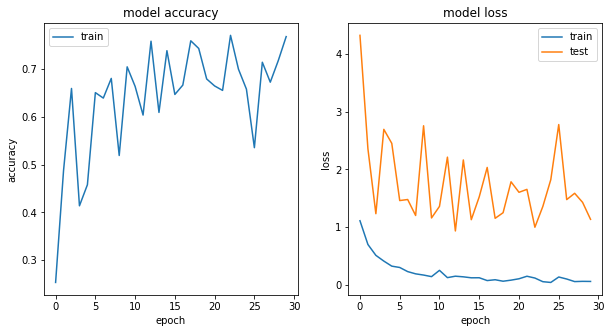

In [15]:
def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
#     plt.plot(history.history['acc'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
 
plot_acc_loss(history)


In [16]:
model.load_weights("transfermodel_best.hdf5")
preds = np.argmax(model.predict(X_val), axis=1)
print("\nAccuracy of Transfer model (softmax) on validation Data: ", accuracy_score(val_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(val_y, preds, normalize=False),"\n")
confusion_matrix(val_y, preds, labels=range(0,11))


Accuracy of Transfer model (softmax) on validation Data:  0.7580174927113703

Number of correctly identified imgaes:  2600 



array([[209,   9,  21,  34,  18,  40,   2,  24,   2,   1,   2],
       [  0, 109,  16,   0,   1,   1,   1,  12,   1,   3,   0],
       [  8,  31, 376,   6,  14,  39,   2,   8,   0,   8,   8],
       [ 10,  15,  43, 197,   4,  18,   6,  18,   1,   1,  14],
       [  9,   7,  11,   9, 236,  38,   1,   9,   2,   2,   2],
       [ 10,   6,  14,   0,   6, 405,   0,   5,   1,   0,   2],
       [  0,   0,   0,   0,   1,   1, 141,   1,   0,   3,   0],
       [  0,   0,   1,   0,   0,   0,   0,  95,   0,   0,   0],
       [ 12,  12,  45,   4,   4,  33,   2,   5, 201,   9,  20],
       [  2,   2,  33,   3,   2,   9,   4,  21,   0, 423,   1],
       [  1,   5,   5,   0,   1,   1,   2,   7,   2,   0, 208]])

In [17]:
print("Reading test images..")
X_test = np.array([cv2.resize(cv2.imread(x), dsize=(224,224), interpolation = cv2.INTER_AREA) for x in test])
print("Done.")

Reading test images..
Done.


In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               409800    
_________________________________________________________________
dense_2 (Dense)              (None, 11)                2211      
Total params: 22,214,795
Trainable params: 22,180,363
Non-trainable params: 34,432
_________________________________________________________________


In [19]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer("dense_1").output)
train_features = intermediate_layer_model.predict(np.array(X_train))
# X_train = []
val_features = intermediate_layer_model.predict(np.array(X_val))
# X_val = []
test_features = intermediate_layer_model.predict(np.array(X_test))
# X_test = []

In [20]:
train_features.shape, val_features.shape, test_features.shape

((9866, 200), (3430, 200), (3347, 200))

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=0) --> 78.83 val acc
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=170) # --> 78.65
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=180) # --> 78.74
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=190) # --> 78.77
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=200) # --> 78.86
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=210) # --> 78.54
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=220) # --> 78.51
# clf = RandomForestClassifier(max_depth=28,n_estimators=150,random_state=230) # --> 78.89
# clf = RandomForestClassifier(max_depth=28,n_estimators=200,random_state=230) # --> 78.92
# clf = RandomForestClassifier(max_depth=28,n_estimators=220,random_state=230) # --> 78.95
# clf = RandomForestClassifier(max_depth=30,n_estimators=220,random_state=230) # --> 78.97
# clf = RandomForestClassifier(max_depth=45,n_estimators=220,random_state=230) # --> 79.06
clf = RandomForestClassifier(max_depth=45,n_estimators=220,random_state=230)
clf.fit(train_features,np.array(train_y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=45, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=220,
                       n_jobs=None, oob_score=False, random_state=230,
                       verbose=0, warm_start=False)

In [22]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf',gamma='scale',decision_function_shape='ovo',probability=True)
svc.fit(train_features,np.array(train_y))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [23]:
SVM_val_outputs = svc.predict(val_features)
SVM_test_outputs = svc.predict(test_features)
SVM_val_outputs.shape, SVM_test_outputs.shape
print("SVM accuracies:")
print("val:",accuracy_score(val_y,SVM_val_outputs))
print("test:",accuracy_score(test_y,SVM_test_outputs))

SVM accuracies:
val: 0.8040816326530612
test: 0.8431431132357335


In [24]:
RF_val_outputs = clf.predict(val_features)
RF_test_outputs = clf.predict(test_features)
RF_val_outputs.shape, RF_test_outputs.shape
print("RF accuracies:")
print("val:",accuracy_score(val_y,RF_val_outputs))
print("test:",accuracy_score(test_y,RF_test_outputs))

RF accuracies:
val: 0.8005830903790088
test: 0.8407529130564685


In [25]:
model.load_weights("transfermodel_best.hdf5")
tm_val = model.predict(X_val)
tm_test = model.predict(X_test)
preds = np.argmax(tm_val, axis=1)
preds2 = np.argmax(tm_test, axis=1)
print("Transfer Model Accuracies:")
print("val:",accuracy_score(val_y,preds))
print("test:",accuracy_score(test_y,preds2))

Transfer Model Accuracies:
val: 0.7580174927113703
test: 0.794741559605617


In [26]:
SVM_val_outputs = svc.predict_proba(val_features)
SVM_test_outputs = svc.predict_proba(test_features)
SVM_val_outputs.shape, SVM_test_outputs.shape

((3430, 11), (3347, 11))

In [27]:
RF_val_outputs = clf.predict_proba(val_features)
RF_test_outputs = clf.predict_proba(test_features)
RF_val_outputs.shape, RF_test_outputs.shape

((3430, 11), (3347, 11))

In [28]:
# SVM accuracies:
# val: 0.7137026239067056
# test: 0.7367792052584404

# RF accuracies:
# val: 0.7160349854227406
# test: 0.7511204063340304

# Transfer Model Accuracies:
# val: 0.5323615160349854
# test: 0.5602031670152375

### Ensembled Validation outputs

In [29]:
w1 = 3.8; w2 = 4.3; w3 = 0# 79
finprobs = []
for i in range(3430):
    p1 = SVM_val_outputs[i].argsort()[-5:][::-1]
    p2 = RF_val_outputs[i].argsort()[-5:][::-1]
    p3 = tm_val[i].argsort()[-5:][::-1]
    p1_scores = sorted(SVM_val_outputs[i])[-5:][::-1]
    p2_scores = sorted(RF_val_outputs[i])[-5:][::-1]
    p3_scores = sorted(tm_val[i])[-5:][::-1]
    probs = [0]*11
    for k in range(5):
        if p1[k]==p2[k] and p1[k] == p3[k]:
            probs[p1[k]] += (w1*p1_scores[k]) + (w2*p2_scores[k]) + (w3*p3_scores[k])
        elif p1[k]==p2[k]:
            probs[p1[k]] += (w1*p1_scores[k]) + (w2*p2_scores[k])
            probs[p3[k]] += (w3*p3_scores[k])
        elif p2[k]==p3[k]:
            probs[p2[k]] += (w2*p2_scores[k]) + (w3*p3_scores[k])
            probs[p1[k]] += (w1*p1_scores[k])
        elif p1[k]==p3[k]:
            probs[p1[k]] += (w1*p1_scores[k]) + (w3*p3_scores[k])
            probs[p2[k]] += (w2*p2_scores[k])
        else:
            probs[p1[k]] += (w1*p1_scores[k])
            probs[p2[k]] += (w2*p2_scores[k])
            probs[p3[k]] += (w3*p3_scores[k])
    probs = np.array(probs).argsort()[-5:][::-1]
    finprobs.append(probs[0])
# print("ensembled!",len(finprobs),len(val_y))
print("val:",accuracy_score(val_y,finprobs))

val: 0.8040816326530612


## Ensembled test outputs

In [30]:
w1 = 2; w2 = 2; w3 = 1.05# 79
finprobs = []
for i in range(3347):
    p1 = SVM_test_outputs[i].argsort()[-5:][::-1]
    p2 = RF_test_outputs[i].argsort()[-5:][::-1]
    p3 = tm_test[i].argsort()[-5:][::-1]
    p1_scores = sorted(SVM_test_outputs[i])[-5:][::-1]
    p2_scores = sorted(RF_test_outputs[i])[-5:][::-1]
    p3_scores = sorted(tm_test[i])[-5:][::-1]
    probs = [0]*11
    for k in range(5):
        if p1[k]==p2[k] and p1[k] == p3[k]:
            probs[p1[k]] += (w1*p1_scores[k]) + (w2*p2_scores[k]) + (w3*p3_scores[k])
        elif p1[k]==p2[k]:
            probs[p1[k]] += (w1*p1_scores[k]) + (w2*p2_scores[k])
            probs[p3[k]] += (w3*p3_scores[k])
        elif p2[k]==p3[k]:
            probs[p2[k]] += (w2*p2_scores[k]) + (w3*p3_scores[k])
            probs[p1[k]] += (w1*p1_scores[k])
        elif p1[k]==p3[k]:
            probs[p1[k]] += (w1*p1_scores[k]) + (w3*p3_scores[k])
            probs[p2[k]] += (w2*p2_scores[k])
        else:
            probs[p1[k]] += (w1*p1_scores[k])
            probs[p2[k]] += (w2*p2_scores[k])
            probs[p3[k]] += (w3*p3_scores[k])

    probs = np.array(probs).argsort()[-5:][::-1]
    finprobs.append(probs[0])
print("ensembled!",len(finprobs),len(test_y))
print("test:",accuracy_score(test_y,finprobs))

ensembled! 3347 3347
test: 0.8416492381236929


## Accuracies
### SVM val: 0.7880466472303207
### RF val: 0.79067055393586
### Transfer model val: 0.7740524781341108
### Ensemble model val: 0.7909620991253644
w1 = 2; w2 = 2; w3 = 1.05 --> test: 0.8096803107260233